## First, getting the training data

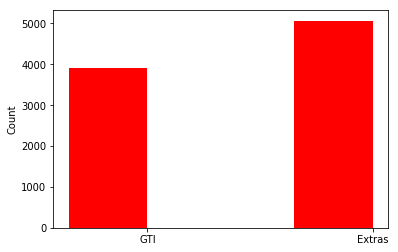

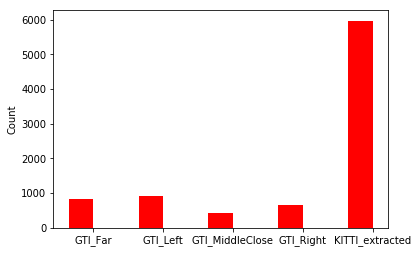

In [48]:
%matplotlib inline

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

non_vehicle_paths = ['training_data/non-vehicles/non-vehicles/GTI/*.png',
                    'training_data/non-vehicles/non-vehicles/Extras/*.png']

vehicle_paths = ['training_data/vehicles/vehicles/GTI_Far/*.png',
                'training_data/vehicles/vehicles/GTI_Left/*.png',
                'training_data/vehicles/vehicles/GTI_MiddleClose/*.png',
                'training_data/vehicles/vehicles/GTI_Right/*.png',
                'training_data/vehicles/vehicles/KITTI_extracted/*.png',]

def image_array(path, color_space='BGR'):
    img_array = []
    images = glob.glob(path)
    for fname in images:
        img = cv2.imread(fname)
        if color_space != 'BGR':
            if color_space == 'RGB':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            elif color_space == 'HSV':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
            elif color_space == 'YCrCb':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        img_array.append(img)
    return np.array(img_array)

def image_arrays_with_distribution(paths):
    array_of_image_arrays = []
    N = 0
    array_lengths = []
    folder_names = []
    for path in paths:
        folder_names.append(path.split('/')[-2])
        N += 1
        img_array = image_array(path, color_space='RGB')
        array_lengths.append(len(img_array))
        array_of_image_arrays.append(img_array)
    ind = np.arange(N)  # the x locations for the groups
    width = 0.35       # the width of the bars
    fig, ax = plt.subplots()
    rects = ax.bar(ind, array_lengths, width, color='r')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(folder_names)
    ax.set_ylabel('Count')
    return array_of_image_arrays

non_vehicles = image_arrays_with_distribution(non_vehicle_paths)
vehicles = image_arrays_with_distribution(vehicle_paths)

non_vehicles_np = np.concatenate(np.array(non_vehicles))
vehicles_np = np.concatenate(np.array(vehicles))

## Second, extract features

In [49]:
from skimage.feature import hog

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, feature_vec=True):
    features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                   feature_vector=feature_vec)
    return features

def extract_features(img_array, spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in img_array:
        feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        
        
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, feature_vec=True)
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        # Return list of feature vectors
    return features

#Parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial = 32
histbin = 32

vehicle_features = extract_features(vehicles_np, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256), orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

non_vehicle_features = extract_features(non_vehicles_np, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256), orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)


## Third, make data suitable for training

In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

# Create an array stack of feature vectors
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

## Fourth, train the model

In [51]:
import time
from sklearn.svm import LinearSVC

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

23.22 Seconds to train SVC...
Test Accuracy of SVC =  0.9879
My SVC predicts:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
0.00236 Seconds to predict 10 labels with SVC


## Fifth, functions for doing slide windows search and applying heatmap

In [102]:
import matplotlib.image as mpimg

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, hog_features=None):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True, scale = 1, ystart = -1, ystop = -1, xstart=-1, xstop=-1):
    ctrans_tosearch = np.copy(img)
    ctrans_tosearch = ctrans_tosearch[ystart:ystop,xstart:xstop,:]
    if scale != 1: #SCALE = 1 means 64, 96 means 1.5
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    ctr = 0
    
    hog_features_array = []
    
    for yb in range(nysteps):
        for xb in range(nxsteps):
            ctr += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            hog_features_array.append(hog_features)
    
    hog_counter = 0
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))     
        
        hog_features = hog_features_array[hog_counter]
        hog_counter += 1
        
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat, hog_features=hog_features)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        if abs(np.min(nonzerox) - np.max(nonzerox)) > 64 and abs(np.min(nonzeroy) - np.max(nonzeroy)) > 64:
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## Sixth, look for cars

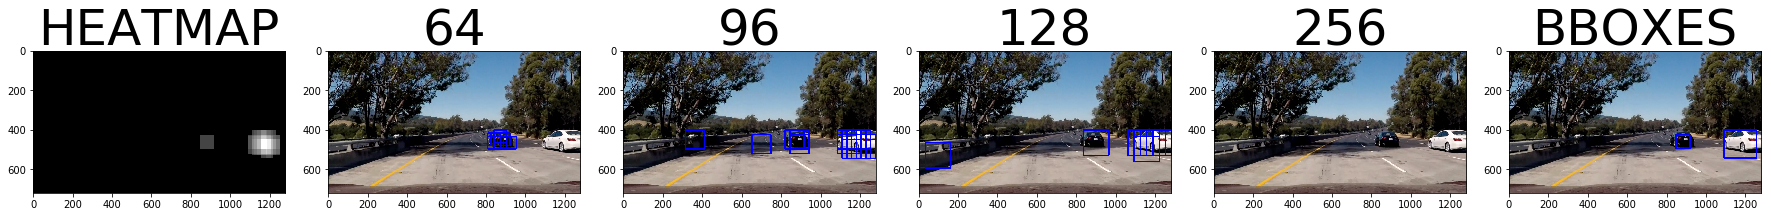

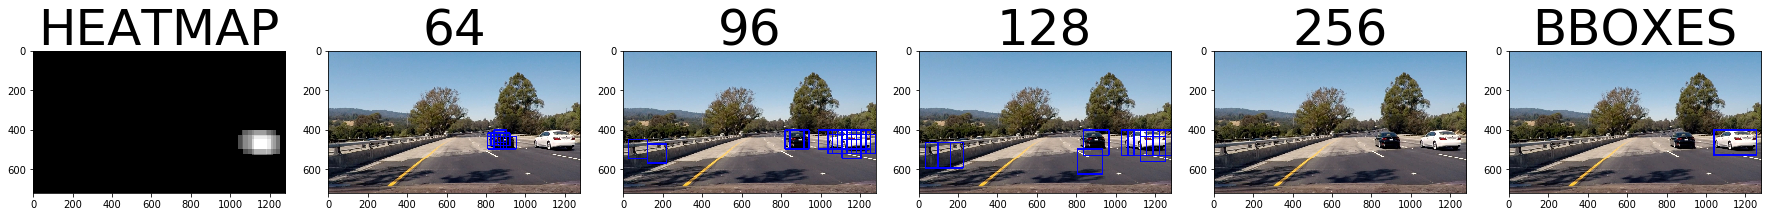

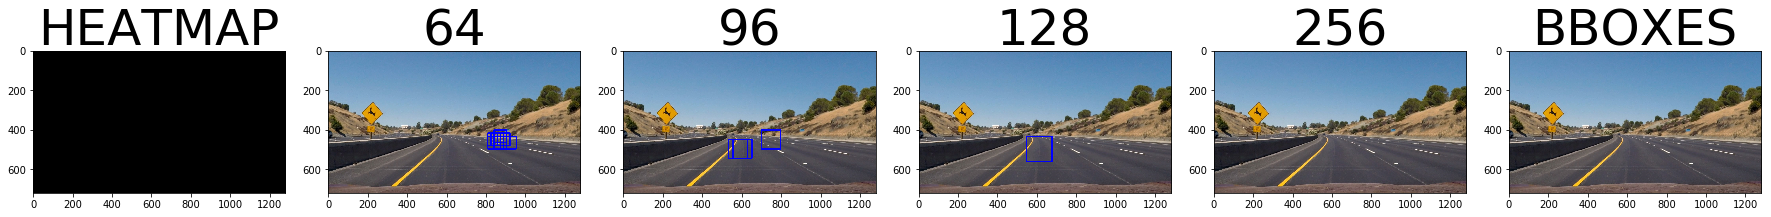

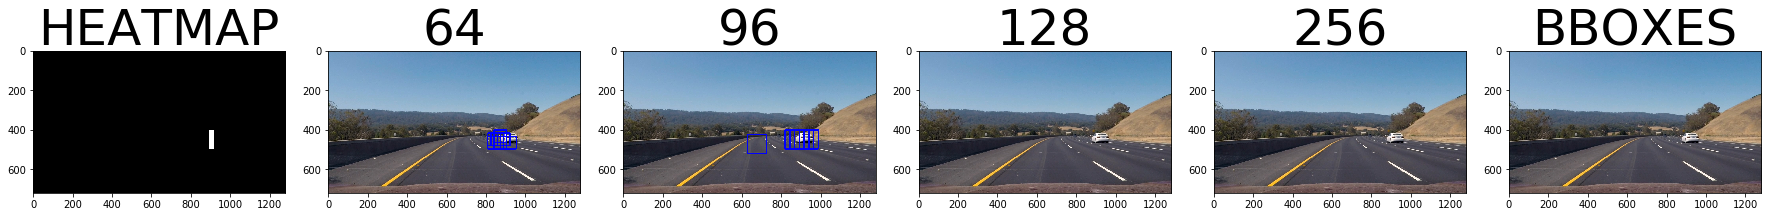

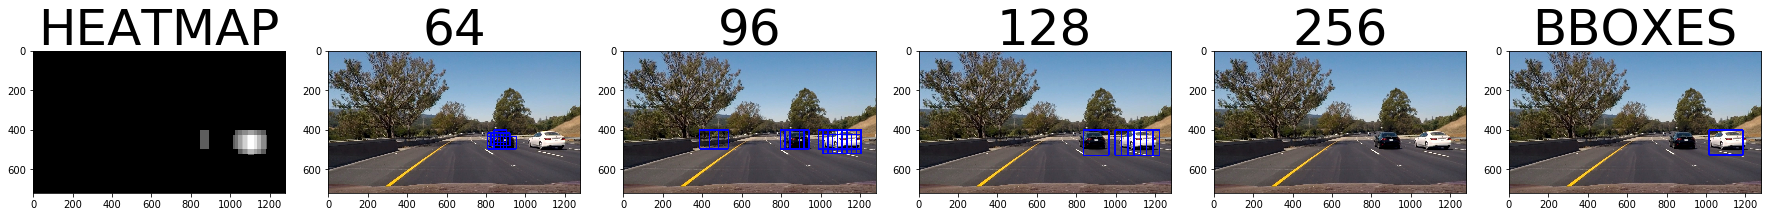

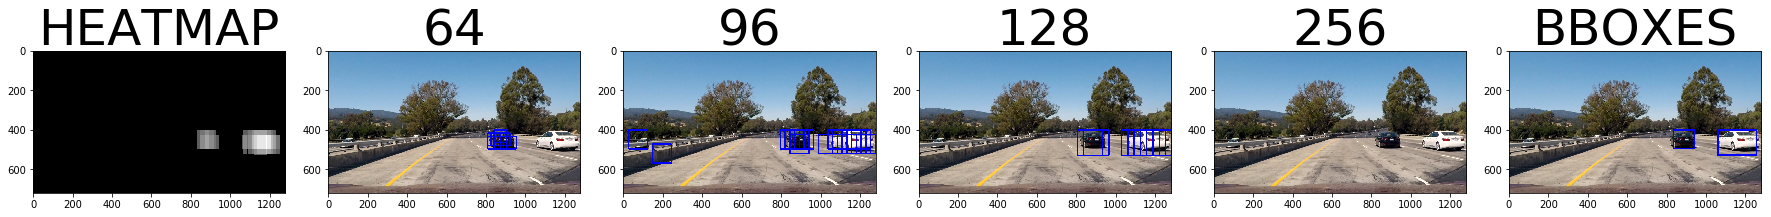

In [108]:
from scipy.ndimage.measurements import label

color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, None] # Min and max in y to search in slide_window()
x_start_stop = [None, None]

images = glob.glob('test_images/test*.jpg')
for fname in images:
    image = mpimg.imread(fname)
    draw_image = np.copy(image)

    #windows64 = slide_window(image, x_start_stop=[200,image.shape[1]-200], y_start_stop=[400, 528], 
    #                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))
    windows96 = slide_window(image, x_start_stop=[4,image.shape[1]-4], y_start_stop=[400, 592], 
                        xy_window=(96, 96), xy_overlap=(0.75, 0.75))
    windows128 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=[400, 700], 
                        xy_window=(128, 128), xy_overlap=(0.75, 0.75))
    #windows256 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=[400, None], 
    #                    xy_window=(256, 256), xy_overlap=(0.75, 0.75))

    #hot_windows64 = search_windows(image, windows64, svc, X_scaler, color_space=color_space, 
    #                        spatial_size=spatial_size, hist_bins=hist_bins, 
    #                        orient=orient, pix_per_cell=pix_per_cell, 
    #                        cell_per_block=cell_per_block, 
    #                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
    #                        hist_feat=hist_feat, hog_feat=hog_feat, scale = 1, ystart=400, ystop=528, xstart=200, xstop=image.shape[1]-200) 
    hot_windows96 = search_windows(image, windows96, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat, scale = 1.5, ystart=400, ystop=592, xstart=4, xstop=(image.shape[1]-4))  
    hot_windows128 = search_windows(image, windows128, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat, scale = 2, ystart=400, ystop=688, xstart=0, xstop=image.shape[1])  
    #hot_windows256 = search_windows(image, windows256, svc, X_scaler, color_space=color_space, 
    #                        spatial_size=spatial_size, hist_bins=hist_bins, 
    #                        orient=orient, pix_per_cell=pix_per_cell, 
    #                        cell_per_block=cell_per_block, 
    #                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
    #                        hist_feat=hist_feat, hog_feat=hog_feat, scale = 4, ystart=400, ystop=image.shape[0], xstart=0, xstop=image.shape[1]) 

    heatmap = np.zeros_like(image[:,:,0])
    #add_heat(heatmap, hot_windows64)
    add_heat(heatmap, hot_windows96)
    add_heat(heatmap, hot_windows128)
    #add_heat(heatmap, hot_windows256)
    heatmap = apply_threshold(heatmap, 3)
    
    labels = label(heatmap)
    
    final_img = draw_labeled_bboxes(image, labels)
    window_img64 = draw_boxes(draw_image, hot_windows64, color=(0, 0, 255), thick=6)    
    window_img96 = draw_boxes(draw_image, hot_windows96, color=(0, 0, 255), thick=6)    
    window_img128 = draw_boxes(draw_image, hot_windows128, color=(0, 0, 255), thick=6)     
    window_img256 = draw_boxes(draw_image, hot_windows256, color=(0, 0, 255), thick=6) 
  
    f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(heatmap, cmap='gray')
    ax1.set_title('HEATMAP', fontsize=50)
    ax2.imshow(window_img64)
    ax2.set_title('64', fontsize=50)
    ax3.imshow(window_img96)
    ax3.set_title('96', fontsize=50)
    ax4.imshow(window_img128)
    ax4.set_title('128', fontsize=50)
    ax5.imshow(window_img256)
    ax5.set_title('256', fontsize=50)
    ax6.imshow(final_img)
    ax6.set_title('BBOXES', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    img64_name = "output_images/img64_" + fname.split('/')[1]
    img96_name = "output_images/img96_" + fname.split('/')[1]
    img128_name = "output_images/img128_" + fname.split('/')[1]
    img256_name = "output_images/img256_" + fname.split('/')[1]
    bboxes_name = "output_images/bboxes_" + fname.split('/')[1]
    
    cv2.imwrite(img64_name, cv2.cvtColor(window_img64,cv2.COLOR_RGB2BGR))
    cv2.imwrite(img96_name, cv2.cvtColor(window_img96,cv2.COLOR_RGB2BGR))
    cv2.imwrite(img128_name, cv2.cvtColor(window_img128,cv2.COLOR_RGB2BGR))
    cv2.imwrite(img256_name, cv2.cvtColor(window_img256,cv2.COLOR_RGB2BGR))
    cv2.imwrite(bboxes_name, cv2.cvtColor(final_img,cv2.COLOR_RGB2BGR))

## Seventh, TrackImage class which contains information from multiple frames

In [109]:
def get_heatmap_all_sizes(image):

    #windows64 = slide_window(image, x_start_stop=[200,image.shape[1]-200], y_start_stop=[400, 528], 
    #                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))
    windows96 = slide_window(image, x_start_stop=[4,image.shape[1]-4], y_start_stop=[400, 592], 
                        xy_window=(96, 96), xy_overlap=(0.75, 0.75))
    windows128 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=[400, 700], 
                        xy_window=(128, 128), xy_overlap=(0.75, 0.75))
    #windows256 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=[400, None], 
    #                    xy_window=(256, 256), xy_overlap=(0.75, 0.75))

    #hot_windows64 = search_windows(image, windows64, svc, X_scaler, color_space=color_space, 
    #                        spatial_size=spatial_size, hist_bins=hist_bins, 
    #                        orient=orient, pix_per_cell=pix_per_cell, 
    #                        cell_per_block=cell_per_block, 
    #                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
    #                        hist_feat=hist_feat, hog_feat=hog_feat, scale = 1, ystart=400, ystop=528, xstart=200, xstop=image.shape[1]-200) 
    hot_windows96 = search_windows(image, windows96, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat, scale = 1.5, ystart=400, ystop=592, xstart=4, xstop=(image.shape[1]-4))  
    hot_windows128 = search_windows(image, windows128, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat, scale = 2, ystart=400, ystop=688, xstart=0, xstop=image.shape[1])  
    #hot_windows256 = search_windows(image, windows256, svc, X_scaler, color_space=color_space, 
    #                        spatial_size=spatial_size, hist_bins=hist_bins, 
    #                        orient=orient, pix_per_cell=pix_per_cell, 
    #                        cell_per_block=cell_per_block, 
    #                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
    #                        hist_feat=hist_feat, hog_feat=hog_feat, scale = 4, ystart=400, ystop=image.shape[0], xstart=0, xstop=image.shape[1]) 

    heatmap = np.zeros_like(image[:,:,0])
    #add_heat(heatmap, hot_windows64)
    add_heat(heatmap, hot_windows96)
    add_heat(heatmap, hot_windows128)
    #add_heat(heatmap, hot_windows256)
    
    return heatmap

class TrackImage:
    def __init__(self, how_many_frames_kept, heatmap_threshold):
        self.heatmaps = []
        self.how_many_frames_kept = how_many_frames_kept   
        self.combined_heatmap = None
        self.heatmap_threshold = heatmap_threshold
    
    def add_frame_to_heatmaps(self, frame):
        heatmap = get_heatmap_all_sizes(frame)
        if len(self.heatmaps) < self.how_many_frames_kept:
            self.heatmaps.append(heatmap)
        else:
            self.heatmaps.pop(0)
            self.heatmaps.append(heatmap)

    def combine_heatmaps(self):
        self.combined_heatmap = np.zeros_like(self.heatmaps[0])
        for heatmap in self.heatmaps:
            self.combined_heatmap = np.add(self.combined_heatmap, heatmap)
        self.combined_heatmap = apply_threshold(self.combined_heatmap, min(self.heatmap_threshold, len(self.heatmaps)*3))
        
    def track_vehicles(self, image):
        self.add_frame_to_heatmaps(image)
        self.combine_heatmaps()
        labels = label(self.combined_heatmap)
        final_img = draw_labeled_bboxes(image, labels)
        return final_img
    
    def track_vehicles_with_heatmap(self, image):
        self.add_frame_to_heatmaps(image)
        self.combine_heatmaps()
        labels = label(self.combined_heatmap)
        final_img = draw_labeled_bboxes(image, labels)
        return (final_img, self.combined_heatmap)


## Eigth, pipeline for processing image

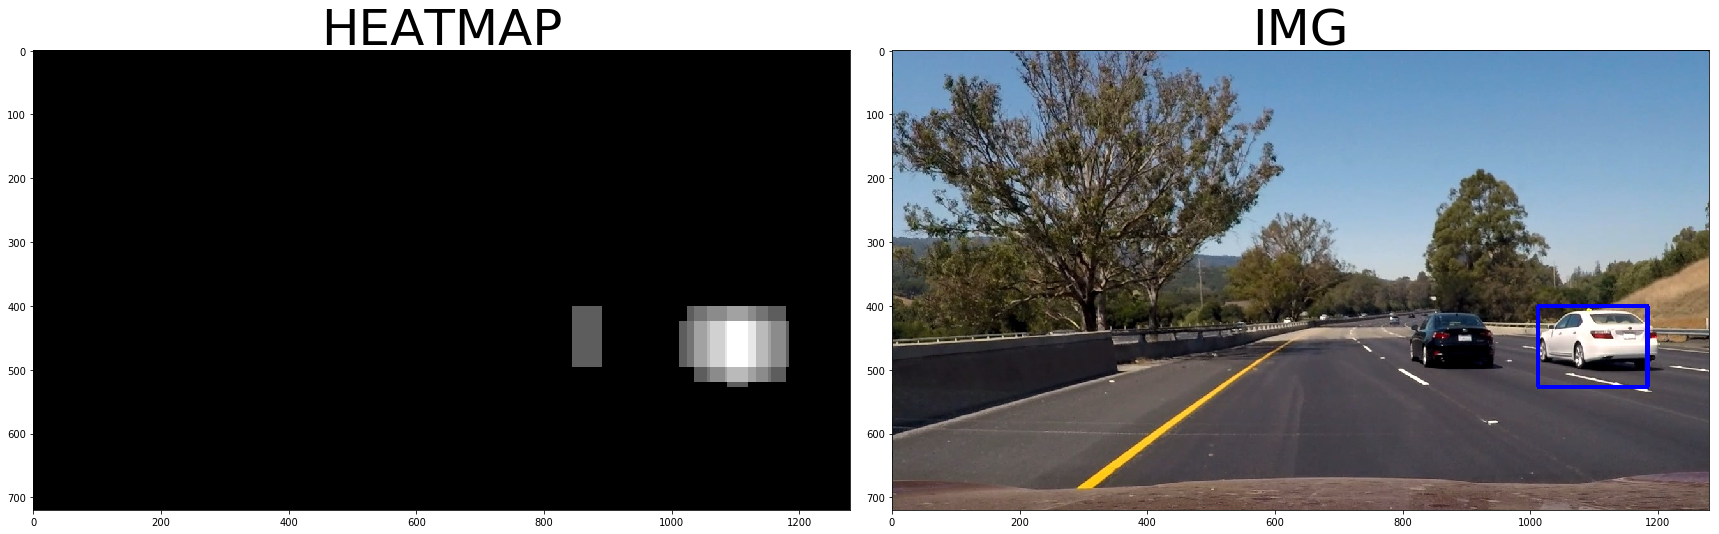

In [113]:
N_frames = 10
threshold = 3*N_frames

def img_with_vehicles(image):
    img_with_vehicles = track_image.track_vehicles(image)
    return img_with_vehicles

rgb = cv2.cvtColor(cv2.imread('test_images/test6.jpg'), cv2.COLOR_BGR2RGB)
track_image = TrackImage(N_frames, threshold)
img, heatmap = track_image.track_vehicles_with_heatmap(rgb)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(heatmap, cmap='gray')
ax1.set_title('HEATMAP', fontsize=50)
ax2.imshow(img)
ax2.set_title('IMG', fontsize=50)

## Ninth, processing video

In [115]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

track_image = TrackImage(N_frames, threshold)

project_output = 'project.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(img_with_vehicles) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project.mp4
[MoviePy] Writing video project.mp4



100%|█████████▉| 1260/1261 [08:54<00:00,  2.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project.mp4 

CPU times: user 12min, sys: 2.74 s, total: 12min 3s
Wall time: 8min 55s
